In [34]:
import importlib
import custom_transform  # import your module once

# After making changes to custom_transform.py
importlib.reload(custom_transform)


<module 'custom_transform' from '/Users/qasimayub/Documents/AI:ML/ATML/PA1/Task 1/custom_transform.py'>

In [41]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import os
from torchvision import transforms
from custom_transform import TranslateTransform, MaskPatchTransform, ShufflePatchTransform 
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from sklearn.manifold import TSNE

# Visualisation Functions

In [3]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(1, 1, -1)
    std = torch.tensor(std).view(1, 1, -1)
    return img * std + mean

def plot_images(dataloader, rows, cols, figsize, title):
    print(title)
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
        img = denormalize(img, imagenet_mean, imagenet_std) # reverse normalization
        img = torch.clamp(img, 0, 1)      # clip to valid range
        
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(1, 1, -1)
    std = torch.tensor(std).view(1, 1, -1)
    return img * std + mean

def visualise_confidence(
    model, loader, device, class_names, num_images=5, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):  
    model.to(device)
    model.eval()

    # Get one batch (for random picking)
    x_all, y_all = next(iter(loader))
    x_all, y_all = x_all.to(device), y_all.to(device)

    fig, axs = plt.subplots(1, num_images, figsize=(3*num_images, 2))
    if num_images == 1:
        axs = [axs]

    for i in range(num_images):
        idx = random.randint(0, len(x_all) - 1)
        img = x_all[idx].unsqueeze(0)  # [1, C, H, W]
        label = y_all[idx].item()

        with torch.no_grad():
            logits = model(img)
            prob = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(prob, dim=1).item()
            confidence = prob[0, pred_label].item()

        # Denormalize and move to [H, W, C]
        img_vis = x_all[idx].detach().cpu().permute(1, 2, 0)
        img_vis = denormalize(img_vis, mean, std).clamp(0, 1)

        # Convert numeric labels to names if class_names provided
        true_name = class_names[label]
        pred_name = class_names[pred_label]

        # Plot
        axs[i].imshow(img_vis)
        axs[i].axis("off")
        axs[i].set_title(f"TL={true_name}, PL={pred_name}\nC={confidence:.2f}")

    plt.tight_layout()
    plt.show()

def per_class_accuracy(model, loader, device, class_names=None):
    model.eval()
    model.to(device)

    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            logits = outputs
            preds = torch.argmax(logits, dim=1)

            for label, pred in zip(labels, preds):
                total_per_class[label.item()] += 1
                if pred.item() == label.item():
                    correct_per_class[label.item()] += 1

    # Compute accuracy per class
    accuracies = {}
    for label in range(len(total_per_class)):
        total = total_per_class[label]
        correct = correct_per_class[label]
        acc = 100.0 * correct / total if total > 0 else 0.0
        name = class_names[label] if class_names is not None else str(label)
        accuracies[name] = acc

    return accuracies


# Loading the model

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

for param in model.parameters():
  param.requires_grad = False
model.fc = torch.nn.Linear(model.fc.in_features, 10)

# Base Datasets

In [5]:
# mean and sd for normalisation
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transform
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [6]:
# Training set
train_dataset = torchvision.datasets.STL10(
    root="./data/stl", split='train', download=False, transform=base_transform
)

# Normal Test set
norm_test_dataset = torchvision.datasets.STL10(
    root="./data/stl", split='test', download=False, transform=base_transform
)

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
norm_test_loader = torch.utils.data.DataLoader(norm_test_dataset, batch_size=64, shuffle=False, num_workers=2)

# get names of classes
class_names = train_dataset.classes

# Train Loop

In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.to(device)
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(inputs)              # forward pass
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.to(device)
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = criterion(logits, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


In [8]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
lossfn = torch.nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("Model - TRAINING")
for i in range(3):
  train_loss, train_acc = train_epoch(model, train_loader, lossfn, optimizer, device)
  print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")
  test_loss, test_acc = evaluate(model, norm_test_loader, lossfn, device)
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")
  train_losses.append(train_loss)
  train_accuracies.append(train_acc)
  test_losses.append(test_loss)
  test_accuracies.append(test_acc)
  if test_acc >= 90:
    break

Model - TRAINING
Train Loss: 0.5825956604957581, Train Accuracy: 86.72
Test Loss: 0.1863788496851921, Test Accuracy: 96.1


## GrayScale

In [9]:
gray_scale_transform = torchvision.transforms.Compose([
  torchvision.transforms.Resize((224, 224)),
  torchvision.transforms.Grayscale(num_output_channels=3),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(imagenet_mean, imagenet_std)
])

# gray scale dataset
grs_test_dataset = torchvision.datasets.STL10(root="./data/stl", split='test', download=False, transform=gray_scale_transform)
grs_test_loader = torch.utils.data.DataLoader(grs_test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [10]:
print("ResNet - Grayscale")
grs_loss, grs_acc = evaluate(model, grs_test_loader, lossfn, device)
print(f"Grayscale Loss: {grs_loss}, Grayscale Accuracy: {grs_acc}")


ResNet - Grayscale
Grayscale Loss: 0.30382591497898104, Grayscale Accuracy: 91.4625


## Cue Conflicted

In [11]:
print("ResNet - Cue Conflict")
cue_test_dataset = torchvision.datasets.ImageFolder(root="./data/cue_conflict_dataset", transform=base_transform)
cue_test_loader = torch.utils.data.DataLoader(cue_test_dataset, batch_size=64, shuffle=False, num_workers=2)
cue_loss, cue_acc = evaluate(model, cue_test_loader, lossfn, device)
print(f"Cue Loss: {cue_loss}, Cue Accuracy: {cue_acc}")
print(f"Shape Bias %: {((cue_acc/test_acc)*100)}")


ResNet - Cue Conflict
Cue Loss: 1.7647782306671143, Cue Accuracy: 38.55
Shape Bias %: 40.11446409989594


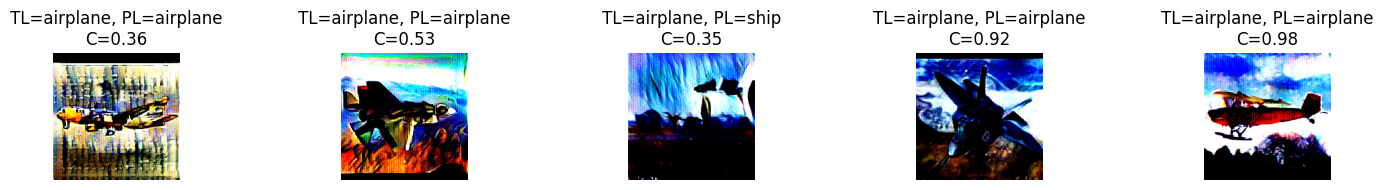

In [94]:
visualise_confidence(model, cue_test_loader, device, class_names)

# Per-class Accuracy

In [13]:
per_class_accuracy(model, cue_test_loader,device, class_names)

{'airplane': 42.375,
 'bird': 63.5,
 'car': 81.125,
 'cat': 54.125,
 'deer': 35.25,
 'dog': 26.125,
 'horse': 17.625,
 'monkey': 5.75,
 'ship': 37.375,
 'truck': 22.25}

# Visualisation

[96.1, 91.4625, 38.55]


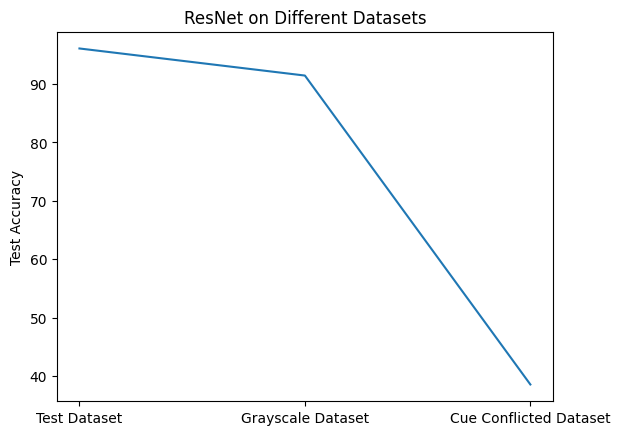

In [87]:
# Visualisation
x = ["Test Dataset", "Grayscale Dataset", "Cue Conflicted Dataset"]
accuracies = [test_acc, grs_acc, cue_acc]
print(accuracies)
plt.plot(x, accuracies)
plt.title("ResNet on Different Datasets")
plt.ylabel("Test Accuracy")
plt.show()

## Translate


In [79]:
translate_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),   # resize to 224x224 for ResNet-S/16
    torchvision.transforms.ToTensor(),           # convert to tensor
    TranslateTransform(40),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std)  # normalize [-1, 1]
])

tr_test_dataset = torchvision.datasets.STL10(root="./data/stl", split="test", download=False, transform=translate_transform)
tr_test_loader = torch.utils.data.DataLoader(tr_test_dataset, batch_size=64, shuffle=False)

In [80]:
tr_loss, tr_acc = evaluate(model, tr_test_loader, lossfn, device)
print(f"Translation Loss: {tr_loss}, Translation Accuracy: {tr_acc}")

Translation Loss: 0.336814372420311, Translation Accuracy: 91.225


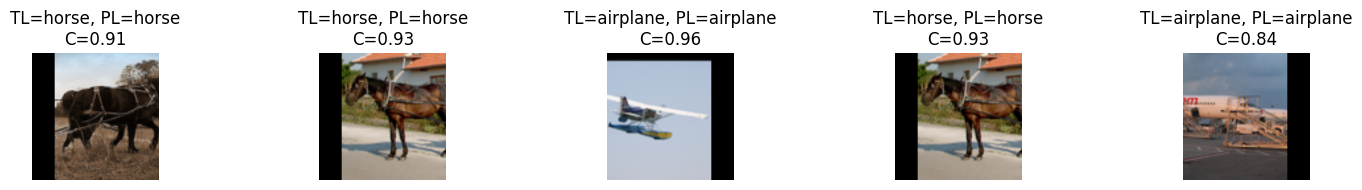

In [81]:
visualise_confidence(model, tr_test_loader, device, class_names)

# Masked

In [21]:
mask_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),   # resize to 224x224 for ResNet-S/16
    torchvision.transforms.ToTensor(),           # convert to tensor
    MaskPatchTransform(25),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std)  # normalize [-1, 1]
])

ms_test_dataset = torchvision.datasets.STL10(root="./data/stl", split="test", download=False, transform=mask_transform)
ms_test_loader = torch.utils.data.DataLoader(ms_test_dataset, batch_size=64, shuffle=False)

In [22]:
ms_loss, ms_acc = evaluate(model, ms_test_loader, lossfn, device)
print(f"Masked Loss: {ms_loss}, Masked Accuracy: {ms_acc}")

Masked Loss: 1.6725980501174926, Masked Accuracy: 42.8125


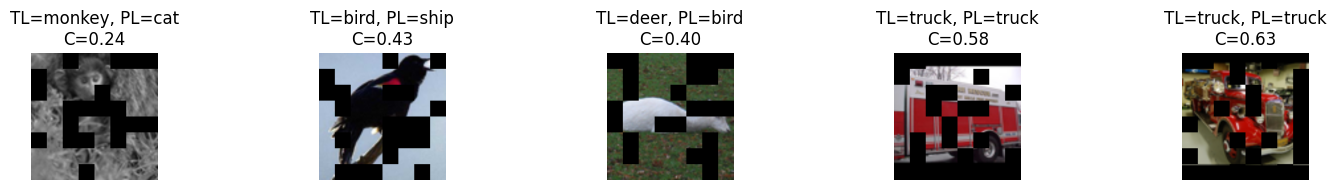

In [25]:
visualise_confidence(model, ms_test_loader, device, class_names)

# Permutation Invariance

In [36]:
perm_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),   # resize to 224x224 for ResNet-S/16
    torchvision.transforms.ToTensor(),           # convert to tensor
    ShufflePatchTransform(),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std)  # normalize [-1, 1]
])

perm_test_dataset = torchvision.datasets.STL10(root="./data/stl", split="test", download=False, transform=perm_transform)
perm_test_loader = torch.utils.data.DataLoader(perm_test_dataset, batch_size=64, shuffle=False)

In [37]:
perm_loss, perm_acc = evaluate(model, perm_test_loader, lossfn, device)
print(f"Permutation Loss: {perm_loss}, Permutation Accuracy: {perm_acc}")

Permutation Loss: 2.936051025390625, Permutation Accuracy: 14.475


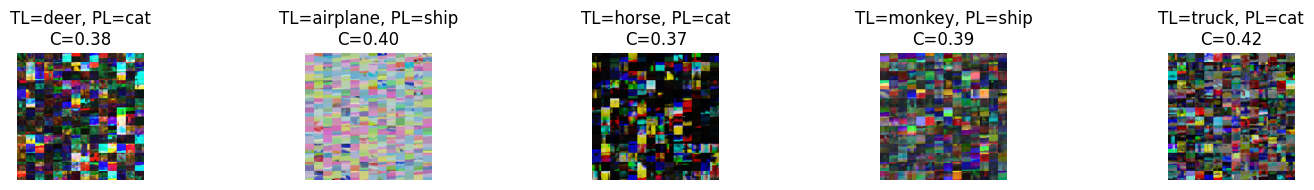

In [38]:
visualise_confidence(model, perm_test_loader, device, class_names)

# Visualisation

[96.1, 91.225, 42.8125, 14.475]


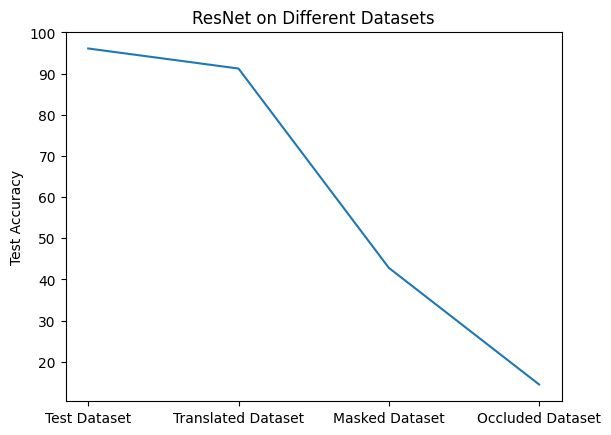

In [88]:
x = ["Test Dataset", "Translated Dataset", "Masked Dataset", "Occluded Dataset"]
accuracies = [test_acc, tr_acc, ms_acc, perm_acc]
print(accuracies)
plt.plot(x, accuracies)
plt.title("ResNet on Different Datasets")
plt.ylabel("Test Accuracy")
plt.show()

# Feature Visualisation

In [92]:
features_map = []
labels = []

def get_feature():
    def hook(model, input, output):
        # append each batch of features
        features_map.append(output.detach().cpu())
    return hook

# Register hooks
model_hook = model.avgpool.register_forward_hook(get_feature())

model.to(device)

model.eval()

with torch.no_grad():
    for x_test, y_test in norm_test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        _ = model(x_test)
        labels.extend(y_test.cpu().numpy())
        if len(labels) > 1000:
            break

model_features  = torch.cat(features_map,  dim=0).view(len(labels), -1)[:1000]
labels = labels[:1000]

model_hook.remove()

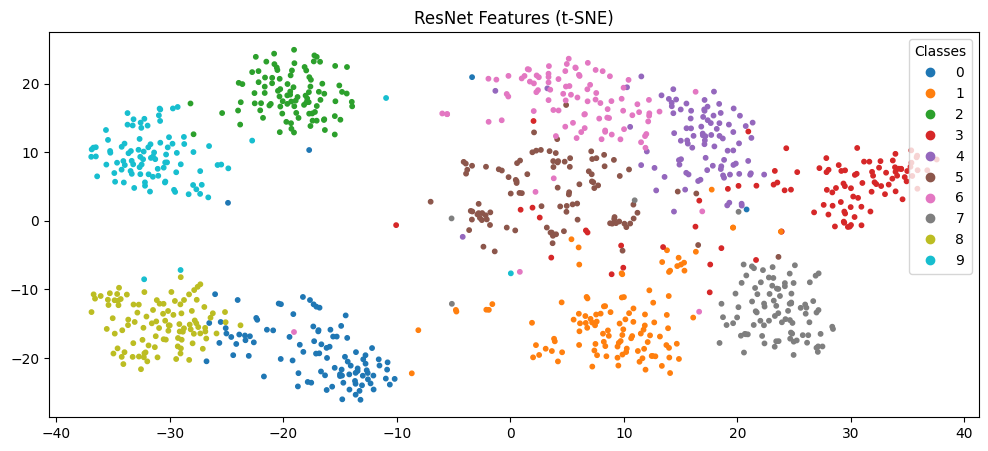

In [93]:
def plot_tsne(model_features, labels, perplexity=30, random_state=42):
    model_features = model_features.cpu().numpy() if hasattr(model_features, "cpu") else np.array(model_features)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=random_state)
    model_2d = tsne.fit_transform(model_features)

    plt.figure(figsize=(12, 5))

    scatter = plt.scatter(model_2d[:,0], model_2d[:,1], c=labels, cmap="tab10", s=10)
    plt.title("ResNet Features (t-SNE)")

    handles, _ = scatter.legend_elements()
    plt.legend(handles, np.unique(labels), title="Classes", loc="upper right")

    plt.show()

plot_tsne(model_features, labels)

# PACS Performance

In [55]:
pacs_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

In [56]:
photo_dataset = torchvision.datasets.ImageFolder(root="data/pacs/photo", transform=base_transform)
art_dataset   = torchvision.datasets.ImageFolder(root="data/pacs/art_painting", transform=base_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(root="data/pacs/cartoon", transform=base_transform)
sketch_dataset  = torchvision.datasets.ImageFolder(root="data/pacs/sketch", transform=base_transform)

# Sketch as Test

In [57]:
pacs_train_set = torch.utils.data.ConcatDataset([photo_dataset, art_dataset, cartoon_dataset])
pacs_test_set = sketch_dataset

pacs_train_loader = torch.utils.data.DataLoader(pacs_train_set, batch_size=64, shuffle=True, num_workers=2)
pacs_test_loader = torch.utils.data.DataLoader(pacs_test_set, batch_size=64, shuffle=False, num_workers=2)

print(f"Train Dataset: {len(pacs_train_set)}")
print(f"Test Dataset: {len(pacs_test_set)}")

Train Dataset: 6062
Test Dataset: 3929


In [ ]:
pacs_out_features = 7

for param in pacs_model.parameters():
  param.requires_grad = False
pacs_model.fc = torch.nn.Linear(pacs_model.fc.in_features, pacs_out_features)

pacs_model_optimizer = torch.optim.Adam(pacs_model.fc.parameters(), lr=0.001)
pacs_model_lossfn = torch.nn.CrossEntropyLoss()

pacs_model_train_losses = []
pacs_model_train_accuracies = []

print("Training Model")
for i in range(4)
  train_loss, train_acc = train_epoch(pacs_model, pacs_train_loader, pacs_model_lossfn, pacs_model_optimizer, device)
  pacs_model_train_losses.append(train_loss)
  pacs_model_train_accuracies.append(train_acc)
  print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")

print("Testing Model")
sketch_loss, sketch_acc = evaluate(pacs_model, pacs_test_loader, pacs_model_lossfn, device)
print(f"Test Loss = {sketch_loss}, Test Accuracy = {sketch_acc}")

Training Model
Train Loss: 0.7362142474550651, Train Accuracy: 78.45595513032002
Train Loss: 0.36883785535069197, Train Accuracy: 89.06301550643352
Train Loss: 0.31347370858103557, Train Accuracy: 89.87132959419334
Train Loss: 0.2779696905319937, Train Accuracy: 91.09204882876938
Testing Model
Test Loss = 1.3635525494533265, Test Accuracy = 48.71468567065411


# Art as Test

In [63]:
pacs_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

In [64]:
pacs_train_set = torch.utils.data.ConcatDataset([photo_dataset, sketch_dataset, cartoon_dataset])
pacs_test_set = art_dataset

pacs_train_loader = torch.utils.data.DataLoader(pacs_train_set, batch_size=64, shuffle=True, num_workers=2)
pacs_test_loader = torch.utils.data.DataLoader(pacs_test_set, batch_size=64, shuffle=False, num_workers=2)

print(f"Train Dataset: {len(pacs_train_set)}")
print(f"Test Dataset: {len(pacs_test_set)}")

Train Dataset: 7943
Test Dataset: 2048


In [65]:
pacs_out_features = 7

for param in pacs_model.parameters():
  param.requires_grad = False

pacs_model.fc = torch.nn.Linear(pacs_model.fc.in_features, pacs_out_features)

pacs_model_optimizer = torch.optim.Adam(pacs_model.fc.parameters(), lr=0.001)
pacs_model_lossfn = torch.nn.CrossEntropyLoss()

pacs_model_train_losses = []
pacs_model_train_accuracies = []

print("Training Model")
for i in range(4):
  train_loss, train_acc = train_epoch(pacs_model, pacs_train_loader, pacs_model_lossfn, pacs_model_optimizer, device)
  pacs_model_train_losses.append(train_loss)
  pacs_model_train_accuracies.append(train_acc)
  print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")

print("Testing Model")
art_loss, art_acc = evaluate(pacs_model, pacs_test_loader, pacs_model_lossfn, device)
print(f"Test Loss = {art_loss}, Test Accuracy = {art_acc}")

Training Model
Train Loss: 0.8679023702919341, Train Accuracy: 70.61563640941709
Train Loss: 0.4875139704912837, Train Accuracy: 83.86000251794033
Train Loss: 0.43978043570110875, Train Accuracy: 84.60279491376055
Train Loss: 0.39030028663713534, Train Accuracy: 86.18909731839355
Testing Model
Test Loss = 1.1512664891779423, Test Accuracy = 60.15625


# Photo as Test

In [66]:
pacs_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

In [67]:
pacs_train_set = torch.utils.data.ConcatDataset([art_dataset, sketch_dataset, cartoon_dataset])
pacs_test_set = photo_dataset

pacs_train_loader = torch.utils.data.DataLoader(pacs_train_set, batch_size=64, shuffle=True, num_workers=2)
pacs_test_loader = torch.utils.data.DataLoader(pacs_test_set, batch_size=64, shuffle=False, num_workers=2)

print(f"Train Dataset: {len(pacs_train_set)}")
print(f"Test Dataset: {len(pacs_test_set)}")

Train Dataset: 8321
Test Dataset: 1670


In [68]:
pacs_out_features = 7

for param in pacs_model.parameters():
  param.requires_grad = False

pacs_model.fc = torch.nn.Linear(pacs_model.fc.in_features, pacs_out_features)

pacs_model_optimizer = torch.optim.Adam(pacs_model.fc.parameters(), lr=0.001)
pacs_model_lossfn = torch.nn.CrossEntropyLoss()

pacs_model_train_losses = []
pacs_model_train_accuracies = []

print("Training Model")
for i in range(4):
  train_loss, train_acc = train_epoch(pacs_model, pacs_train_loader, pacs_model_lossfn, pacs_model_optimizer, device)
  pacs_model_train_losses.append(train_loss)
  pacs_model_train_accuracies.append(train_acc)
  print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")

print("Testing Model")
photo_loss, photo_acc = evaluate(pacs_model, pacs_test_loader, pacs_model_lossfn, device)
print(f"Test Loss = {photo_loss}, Test Accuracy = {photo_acc}")

Training Model
Train Loss: 0.9740052160456295, Train Accuracy: 68.21295517365701
Train Loss: 0.5977032284025475, Train Accuracy: 79.84617233505588
Train Loss: 0.5381003224982935, Train Accuracy: 81.16812883066939
Train Loss: 0.4977785167664293, Train Accuracy: 82.4299963946641
Testing Model
Test Loss = 0.27968758533145494, Test Accuracy = 91.01796407185628


# Cartoon as Test

In [69]:
pacs_model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V1)

In [70]:
pacs_train_set = torch.utils.data.ConcatDataset([art_dataset, sketch_dataset, photo_dataset])
pacs_test_set = cartoon_dataset

pacs_train_loader = torch.utils.data.DataLoader(pacs_train_set, batch_size=64, shuffle=True, num_workers=2)
pacs_test_loader = torch.utils.data.DataLoader(pacs_test_set, batch_size=64, shuffle=False, num_workers=2)

print(f"Train Dataset: {len(pacs_train_set)}")
print(f"Test Dataset: {len(pacs_test_set)}")

Train Dataset: 7647
Test Dataset: 2344


In [71]:
pacs_out_features = 7

for param in pacs_model.parameters():
  param.requires_grad = False

pacs_model.fc = torch.nn.Linear(pacs_model.fc.in_features, pacs_out_features)

pacs_model_optimizer = torch.optim.Adam(pacs_model.fc.parameters(), lr=0.001)
pacs_model_lossfn = torch.nn.CrossEntropyLoss()

pacs_model_train_losses = []
pacs_model_train_accuracies = []

print("Training Model")
for i in range(4):
  train_loss, train_acc = train_epoch(pacs_model, pacs_train_loader, pacs_model_lossfn, pacs_model_optimizer, device)
  pacs_model_train_losses.append(train_loss)
  pacs_model_train_accuracies.append(train_acc)
  print(f"Train Loss: {train_loss}, Train Accuracy: {train_acc}")

print("Testing Model")
cartoon_loss, cartoon_acc = evaluate(pacs_model, pacs_test_loader, pacs_model_lossfn, device)
print(f"Test Loss = {cartoon_loss}, Test Accuracy = {cartoon_acc}")

Training Model
Train Loss: 0.8446300001070829, Train Accuracy: 72.82594481496011
Train Loss: 0.5025865766399434, Train Accuracy: 83.28756375049039
Train Loss: 0.4339401066513705, Train Accuracy: 85.26219432457172
Train Loss: 0.4066912228568202, Train Accuracy: 85.81142931868706
Testing Model
Test Loss = 1.5316672099328286, Test Accuracy = 50.46928327645051


# Combined Visualisation

[48.71468567065411, 60.15625, 91.01796407185628, 50.46928327645051]


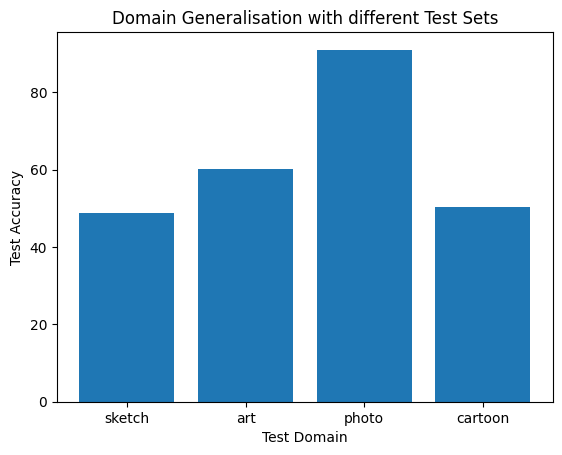

In [90]:
accs = [sketch_acc, art_acc, photo_acc, cartoon_acc]
labels = ["sketch", "art", "photo", "cartoon"]
print(accs)
plt.bar(labels, accs)
plt.title("Domain Generalisation with different Test Sets")
plt.xlabel("Test Domain")
plt.ylabel("Test Accuracy")
plt.show()